In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 4007)


In [2]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', lambd=1e-5, **kwargs):
        n_steps = T.iscalar()
        self.optim = LSTM_Optimizer(n_steps=n_steps, function=func, input_var=input_var, **kwargs)
        self.params_init = L.layers.get_all_param_values(self.optim.l_rec)

        #theta_history, loss_history, scan_updates = L.layers.get_output(self.l_optim)
        theta_history, loss_history, scan_updates = self.optim.optimize(input_var)

        self.loss_type = loss_type
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = T.log(loss_history).sum()
        elif loss_type == 'weighted_prod':
            loss = (T.log(loss_history) * 0.9**T.arange(loss_history.shape[0])[::-1]).sum()
        elif loss_type == 'norm_sum':
            loss = loss_history[1:].sum() / loss_history[0]
        elif loss_type == 'rel_sum':
            loss = (loss_history[1:] / loss_history[:-1]).sum()
                
        loss += lambd * L.regularization.regularize_network_params(self.optim.l_rec, L.regularization.l2)
                
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.optim.l_rec)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        updates.update(scan_updates)
        
        import time
        
        t = time.time()
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True, updates=scan_updates)
        print("Time compiling loss_fn: {}".format(time.time() - t))
        
        t = time.time()
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        print("Time compiling train_fn: {}".format(time.time() - t))
        
#         theta_history_det, loss_history_det, scan_updates_det = L.layers.get_output(self.optim.l_rec, deterministic=True)
#         self.loss_det_fn = theano.function([input_var, n_steps] + func_params, [theta_history_det, loss_history_det], allow_input_downcast=True, updates=scan_updates_det)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.optim.l_rec, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        optimizer_loss = []
        optimizer_moving_loss = []
        moving_loss = None

        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                if self.loss_type == 'sum':
                    loss = np.sum(loss_history)
                elif self.loss_type == 'prod':
                    loss = np.sum(np.log(loss_history))
                elif self.loss_type == 'weighted_prod':
                    loss = (np.log(loss_history) * 0.9**np.arange(loss_history.shape[0])[::-1]).sum()
                elif loss_type == 'norm_sum':
                    loss = loss_history[1:].sum() / loss_history[0]
                elif loss_type == 'rel_sum':
                    loss = ((loss_history[1:] - loss_history[:-1]) / loss_history[:-1]).sum()
                training_loss_history.append(loss_history)
            
                optimizer_loss.append(loss)
                if moving_loss is None:
                    moving_loss = loss
                else:
                    moving_loss = 0.9 * moving_loss + 0.1 * loss
                optimizer_moving_loss.append(moving_loss)

            display.clear_output(wait=True)

            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [3]:
class RosenbrockFunction:
    def __init__(self, theta=None, a=None, b=None):
        self.a = a or T.scalar('a')
        self.b = b or T.scalar('b')

        self.theta = theta or T.vector('theta')
        
        print("Theta ndim: {}".format(self.theta.ndim))
        
        self.func = (self.a - self.theta[0])**2 + self.b * (theta[1] - theta[0]**2)**2
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.a, self.b]

In [4]:
A = T.scalar()
B = T.scalar()
    
func = lambda theta: RosenbrockFunction(theta, A, B).func

In [5]:
input_var = T.vector()

In [6]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, A, B, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

Theta ndim: 1


In [7]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, A, B, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

Theta ndim: 1


In [12]:
%run ../lstm_optimizer.py

In [13]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
    'preprocess_input': False,
    
    'p_drop_grad': 0.0,
    'p_drop_delta': 0.0,
    'p_drop_coord': 0.0,
    
    'loss_type': 'sum',
}

for n_gac in [0]:#for n_gac in [0, 5]:
    for loglr in [False]:#for loglr in [False, True]: 
        for loss_type in ['sum']:#for loss_type in ['sum', 'norm_sum', 'rel_sum']:
            options['n_gac'] = n_gac
            options['loglr'] = loglr

            key = "n_gac={}; loglr={}; loss_type={}".format(n_gac, loglr, loss_type)
            if options.get(key, None) is None:
                lstm_optimizers[key] = LSTMOptimizer(input_var, func, [A, B], **options)
                print(key)

None 2
None 2
None 2
None 1
None 2
Input ndim: 1
Theta ndim: 1
Time compiling loss_fn: 1.9315311908721924
Time compiling train_fn: 57.09921932220459
n_gac=0; loglr=False; loss_type=sum


In [14]:
# def sample_params(ndim=None):
#     ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
#     W = np.cast['float32'](np.random.randn(ndim, ndim))
#     b = np.cast['float32'](np.random.randn(ndim))
#     return W, b

# def sample_point(ndim):
#     theta = np.cast['float32'](np.random.randn(ndim))
#     return theta

# def sample_point_and_params(ndim=None):
#     W, b = sample_params(ndim)
#     theta = sample_point(len(b))
    
#     return theta, (W, b)

def sample_point(ndim=2):
    return np.zeros(2)

def sample_params(ndim=None):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None):
    a, b = sample_params(ndim)
    theta = sample_point(ndim)
    
    return theta, (a, b)

In [15]:
training_options = {
    'n_epochs': 15,
    'batch_size': 100,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    opt.reset_network()
    opt.lr.set_value(0.005)

    sampler = sample_point_and_params
    
    for n_iter in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        training_options['n_iter'] = n_iter
        opt.train(sampler, **training_options)

Epoch number 5
Time on epoch 5: 7.042681694030762
Loss on 5: 89.51627349853516; 1.4885245561599731


KeyboardInterrupt: 

In [12]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [ ]:
# for name, opt in lstm_optimizers.items():
#     with open('quadratic_optimizer_drop_coord_low_dim({}).npz'.format(name), 'wb') as f:
#         np.savez(f, L.layers.get_all_param_values(opt.l_optim))

In [ ]:
# for name, opt in lstm_optimizers.items():
#     with np.load('quadratic_optimizer_drop_coord_low_dim({}).npz'.format(name)) as f:
#         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
#     L.layers.set_all_param_values(opt.l_optim, param_values[0])

In [ ]:
import itertools

generalization_loss_lstm = {}
for name in lstm_optimizers:
    generalization_loss_lstm[name] = []
#     generalization_loss_lstm[name + "_det"] = []

for n_c in itertools.chain(range(2, 150), range(900, 1000)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
#         losses_det = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
#             loss_det = opt.loss_det_fn(theta, 100, W_, b_)[1][-1]
            
            losses.append(loss)
#             losses_det.append(loss_det)
    
        generalization_loss_lstm[name].append(np.mean(losses))
#         generalization_loss_lstm[name + "_det"].append(np.mean(losses_det))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))

for name, losses in sorted(generalization_loss_lstm.items()): 
    if name.find('False') == -1:
        linestyle = 'solid'
    else:
        linestyle = '--'
        
    ax1.semilogy(list(range(2, 150)) + list(range(900, 1000)), losses[:], label=name, linestyle=linestyle)
    ax2.semilogy(list(range(2, 150)), losses[:148], label=name, linestyle=linestyle)
    ax3.semilogy(list(range(22, 150)) + list(range(900, 1000)), losses[20:], label=name, linestyle=linestyle)
    
# fig.legend(loc=4);
ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=2)
fig.tight_layout()

In [13]:
def test_optimizers(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
#         loss_history_det = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
#             loss_history_det.append(opt.loss_det_fn(theta, testing_options['n_iter'], W_, b_)[1])
            
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)
#         histories['lstm_det; {}'.format(key)] = np.median(loss_history_det, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history
    return histories

In [14]:
testing_options = {
    'n_iter': 60,
    'n_functions': 50,
    'sampler': sample_point_and_params
}

histories_60 = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=False; loss_type=sum
Testing momentum


In [15]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
    'sampler': sample_point_and_params
}

histories_500 = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=False; loss_type=sum
Testing momentum


In [16]:
testing_options = {
    'n_iter': 500,
    'n_functions': 1,
    'sampler': sample_point_and_params
}

histories_1_func = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=False; loss_type=sum
Testing momentum


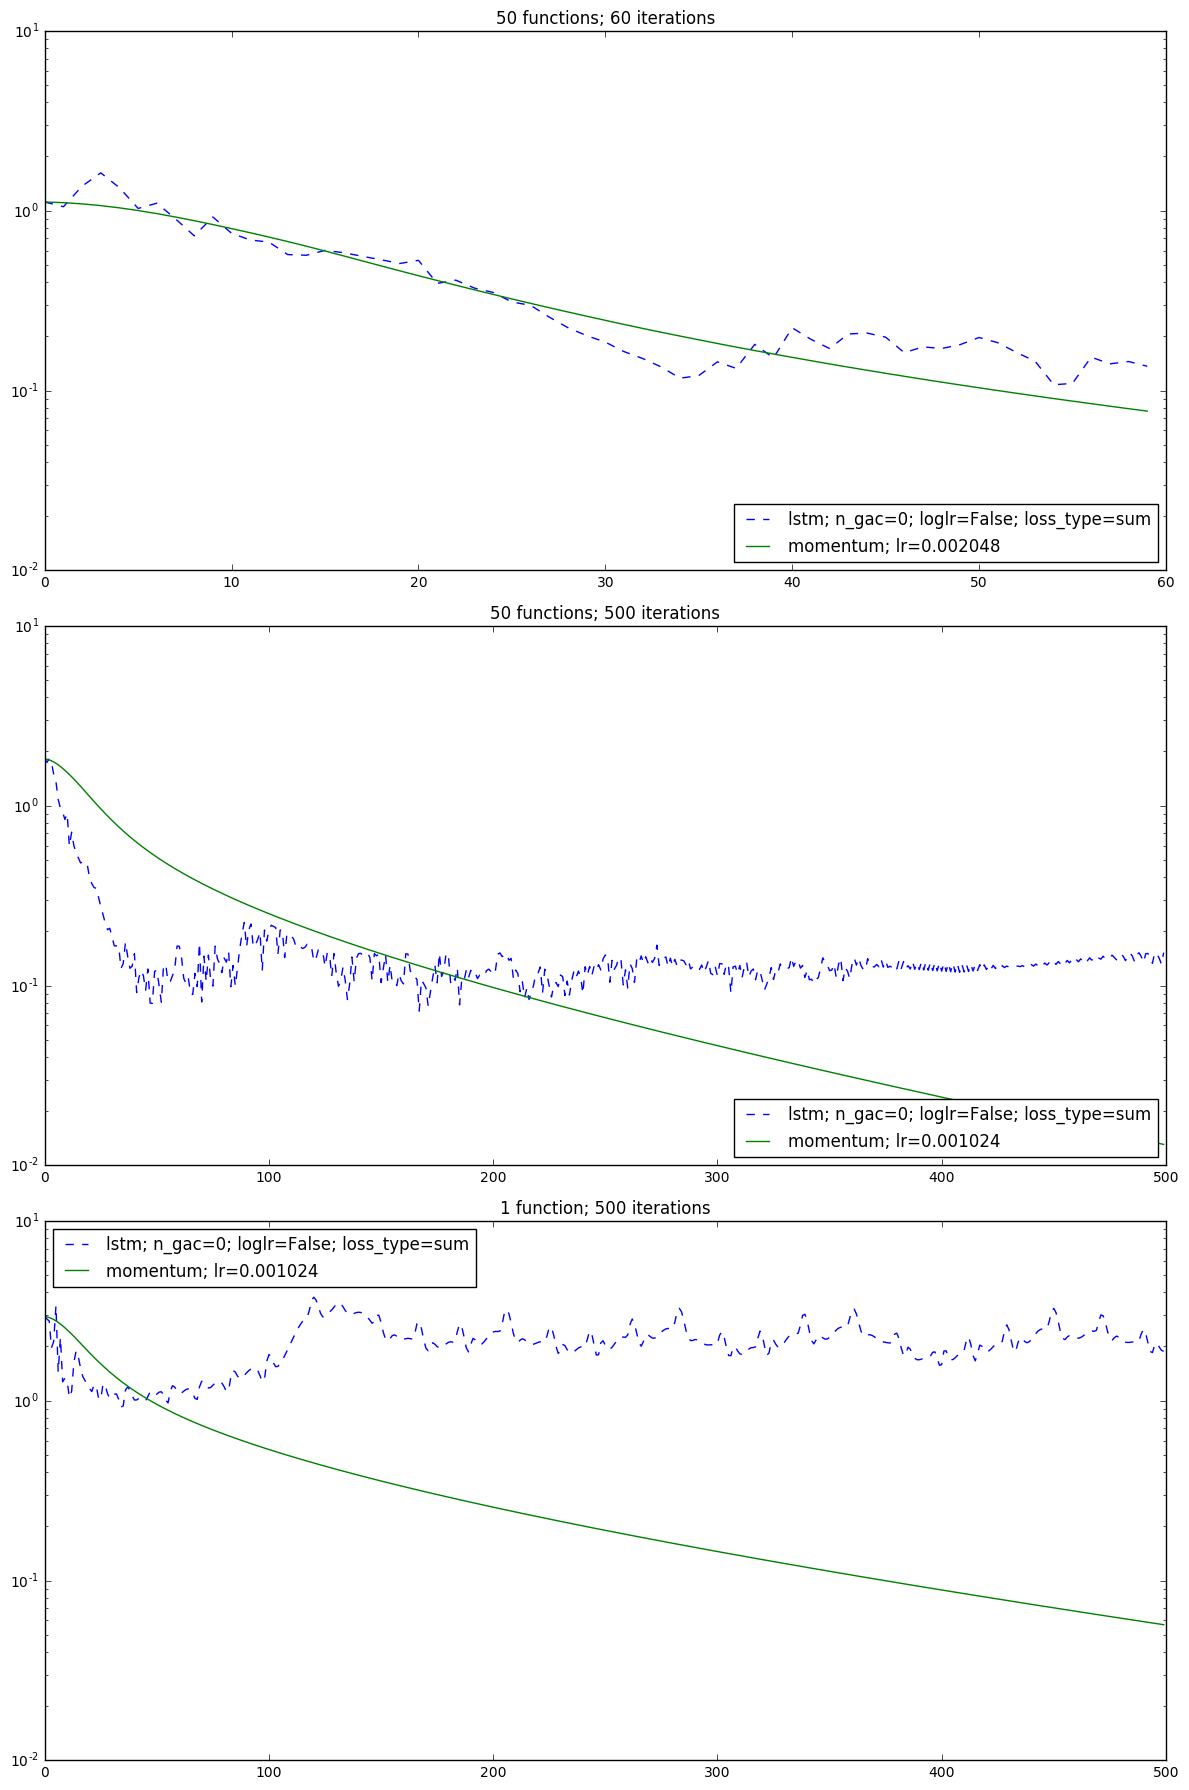

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

for name in sorted(set(list(histories_60.keys()) + list(histories_500.keys()) + list(histories_1_func.keys()))):
    if name.find('det') != -1:
        continue
    if name.find('False') == -1:
        linestyle = 'solid'
    else:
        linestyle = '--'
        
    if histories_60.get(name) is not None:
        ax1.semilogy(histories_60[name], label=name, linestyle=linestyle)
    if histories_500.get(name) is not None:
        ax2.semilogy(histories_500[name], label=name, linestyle=linestyle)
    if histories_1_func.get(name) is not None:
        ax3.semilogy(histories_1_func[name], label=name, linestyle=linestyle)
    
# fig.legend(loc=4);
ax1.set_title('50 functions; 60 iterations')
ax2.set_title('50 functions; 500 iterations')
ax3.set_title('1 function; 500 iterations')
ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=2)
fig.tight_layout()

In [ ]:
theta, (a_, b_) = sample_point_and_params(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [a_, b_], 100)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)
    
#     history, losses = opt.loss_det_fn(theta, 100, W_, b_)
#     history = np.concatenate([theta.reshape(1, -1), history], axis=0)
#     sample_runs[name+'_det'] = (history, losses)


sample_runs['momentum'] = momentum_fn(theta, 100, a_, b_, 0.001)

In [ ]:
# theta_opt = np.linalg.pinv(W_).dot(b_)
theta_opt = (a_, a_**2)

min_x = min(sample_runs[list(lstm_optimizers.keys())[1]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[1]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[1]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[1]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
X, Y = np.meshgrid(x, y)

# Z = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
#         Z[i][j] = z

Z = (a_ - X)**2 + b_ * (Y - X**2)**2
        
plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in sample_runs:
    history, lss = sample_runs[name]
    if lss[-1] > 0.1:#or name.find('fix=False') == -1:
        continue
    linestyle = 'solid'
#     if name.find('0.0') != -1 and name.find('det') != -1:
#         continue
#     if name.find('det') == -1:
#         linestyle = 'solid'
#     elif name.find('fix=False') != -1:
#         linestyle = '-.'
#     else:
#         linestyle = '--'
    plt.plot(history.T[0], history.T[1], linestyle=linestyle, label=name, marker='x')

# history, _ = sample_runs['momentum']
# plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

In [ ]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in sample_runs:
    _, losses = sample_runs[name]
    if losses[-1] > 0.1:#or name.find('fix=False') == -1:
        continue

#     if name.find('det') != -1:
#         continue
#     if name.find('False') != -1:
#         linestyle = 'solid'
#     else:
#         linestyle = '--'
        
    plt.semilogy(losses, label=name, linestyle=linestyle)

# _, losses = sample_runs['momentum']    
# plt.semilogy(losses, label='momentum', linestyle='--')
plt.legend();